In [8]:
import os
import sagemaker

from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

SETTINGS

In [9]:
base_job_name = 'trainin-job-simple-03'

CREATE FOLDER TO SAVE TRAINING CODE

In [10]:
os.makedirs("training_code_03", exist_ok=True) # Create folder for training code

CREATE TRAINING ENTRY POINT

In [19]:
%%writefile training_code_03/start_file.py

from __future__ import print_function

import argparse
import joblib
import os
import pandas as pd

from sklearn.linear_model import LogisticRegression

if __name__ == '__main__':
    model_dir = os.environ['SM_MODEL_DIR'] # Folder where model must be saved
    train_dir = os.environ['SM_CHANNEL_TRAIN'] # Folder where train data is stored

    # Lets assume there is only one training file
    train_file_name = os.listdir(train_dir)[0]
    train_file_path = os.path.join(train_dir, train_file_name)
    
    train_data = pd.read_csv(train_file_path, header=None, engine="python")

    # labels are in the first column
    train_y = train_data.iloc[:, 0]
    train_X = train_data.iloc[:, 1:]  

    # Train the model
    # Hyperparameters are hardcoded
    clf = LogisticRegression(max_iter=100)
    clf = clf.fit(train_X, train_y)

    # Save model object
    joblib.dump(clf, os.path.join(model_dir, "model.joblib"))

    script_content = """
import os
import joblib
import numpy as np

def model_fn(model_dir):
    model_path = os.path.join(model_dir, 'model.joblib')
    model = joblib.load(model_path)
    return model

def predict_fn(input_data, model):
    prediction = model.predict_proba(input_data)
    return prediction
"""
    script_path = os.path.join(model_dir, "inference.py")
    with open(script_path, "w") as f:
        f.write(script_content)
    print(f"Inference script created at {script_path}")

Overwriting training_code_03/start_file.py


CREATE NECCESSARY OBJECTS

In [16]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()

CREATE ESTIMATOR OBJECT

In [17]:
sklearn = SKLearn(
    entry_point='start_file.py', # The file with the training code
    source_dir='training_code_03', # The folder with the training code
    framework_version='1.2-1', # Version of SKLearn which will be used
    instance_type='ml.m5.large', # Instance type that wil be used
    role=role, # Role that will be used during execution
    sagemaker_session=sagemaker_session, 
    base_job_name=base_job_name # Name of the training job. Timestamp will be added as suffix
)

FIT THE MODEL
- The fit function have one required parameter in the form of a dictionary.
- The key represents the "channel" of the data. Typically it is train, test, valid. The names can be arbitrary.
- The value contains path to S3 folder that contains the data

The data from all channels will be copied to the training instance.

To obtain LOCAL path to the data one should use os.environ['SM_CHANNEL_CHANNEL'] and replace CHANNEL by actual channel name

Example:

If we specify following dictionary {"train": "s3://sagemaker-bucket-ds/training-jobs/data/train/"} then in the training script the path to the training data is in the object os.environ['SM_CHANNEL_TRAIN']


In [18]:
sklearn.fit({"train": "s3://sagemaker-bucket-ds/training-jobs/data/train/"})

INFO:sagemaker:Creating training-job with name: trainin-job-simple-03-2024-07-01-14-30-07-755


2024-07-01 14:30:08 Starting - Starting the training job...
2024-07-01 14:30:26 Starting - Preparing the instances for training...
2024-07-01 14:30:57 Downloading - Downloading input data...
2024-07-01 14:31:27 Downloading - Downloading the training image......
2024-07-01 14:32:33 Training - Training image download completed. Training in progress..2024-07-01 14:32:36,372 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-07-01 14:32:36,376 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-01 14:32:36,378 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-07-01 14:32:36,539 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-07-01 14:32:36,836 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-07-01 14:32:36,839 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)

The job is executing
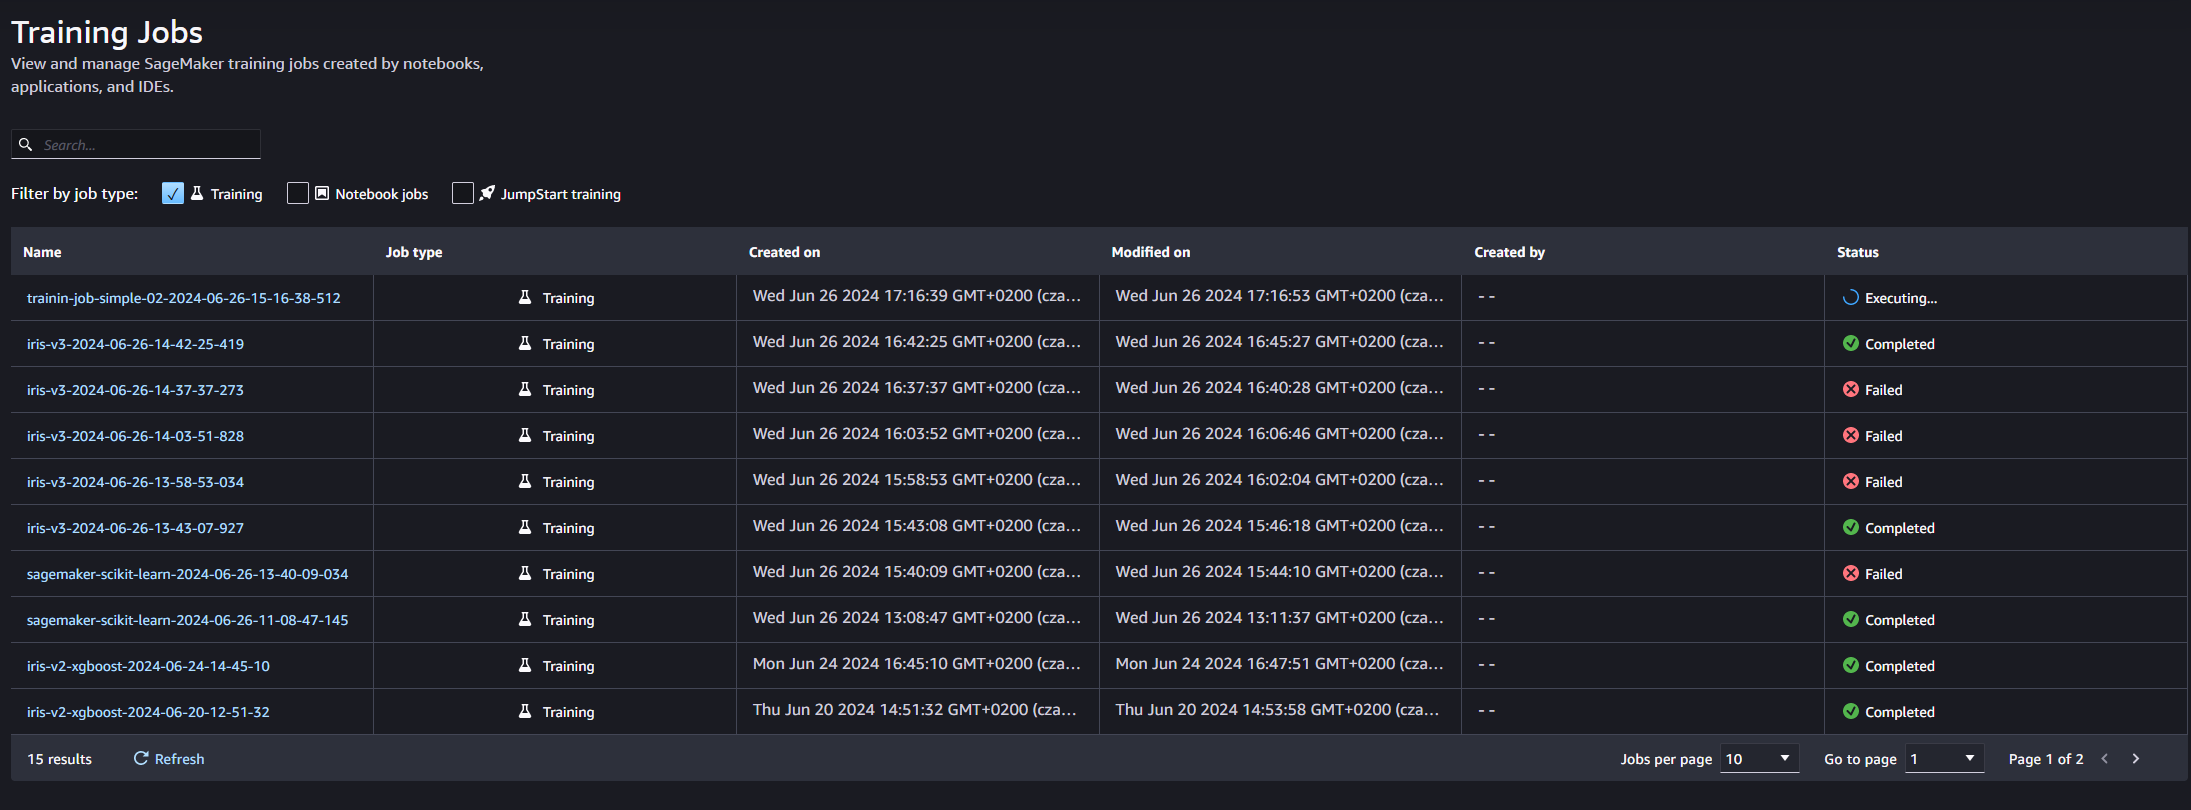